In [1]:
%pip install pulp
%pip install pyomo
%pip install plotly
%pip install statsmodels

# Import Required Libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import pulp
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus, value
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory
import warnings
warnings.filterwarnings('ignore')

import os
import gc
from pandas.tseries.offsets import Week

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Exploratory Data Analysis - Instacart Dataset

Notebook này thực hiện phân tích khám phá dữ liệu (EDA) trên bộ dữ liệu Instacart để hiểu:
1. Phân bố đơn hàng theo thời gian
2. Hành vi mua sắm của khách hàng
3. Đặc điểm sản phẩm và tái mua
4. Pattern mua sắm theo department/aisle

In [3]:
# Đường dẫn tới thư mục data
DATA_DIR = 'C:/Users/binhd/Downloads/New folder/data'

# Load dữ liệu
aisles = pd.read_csv(os.path.join(DATA_DIR, 'aisles.csv'))
departments = pd.read_csv(os.path.join(DATA_DIR, 'departments.csv'))
order_prior = pd.read_csv(os.path.join(DATA_DIR, 'order_products__prior.csv'))
order_train = pd.read_csv(os.path.join(DATA_DIR, 'order_products__train.csv'))
orders = pd.read_csv(os.path.join(DATA_DIR, 'orders.csv'))
products = pd.read_csv(os.path.join(DATA_DIR, 'products.csv'))

print("\nKích thước các DataFrame:")
print(f"aisles: {aisles.shape}")
print(f"departments: {departments.shape}")
print(f"order_prior: {order_prior.shape}")
print(f"order_train: {order_train.shape}")
print(f"orders: {orders.shape}")
print(f"products: {products.shape}")


Kích thước các DataFrame:
aisles: (134, 2)
departments: (21, 2)
order_prior: (32434489, 4)
order_train: (1384617, 4)
orders: (3421083, 7)
products: (49688, 4)


# 1. Phân tích Sản phẩm và Danh mục

Phân tích về:
- Phân bố sản phẩm theo department và aisle
- Top sản phẩm được mua nhiều nhất
- Tỷ lệ tái mua theo danh mục

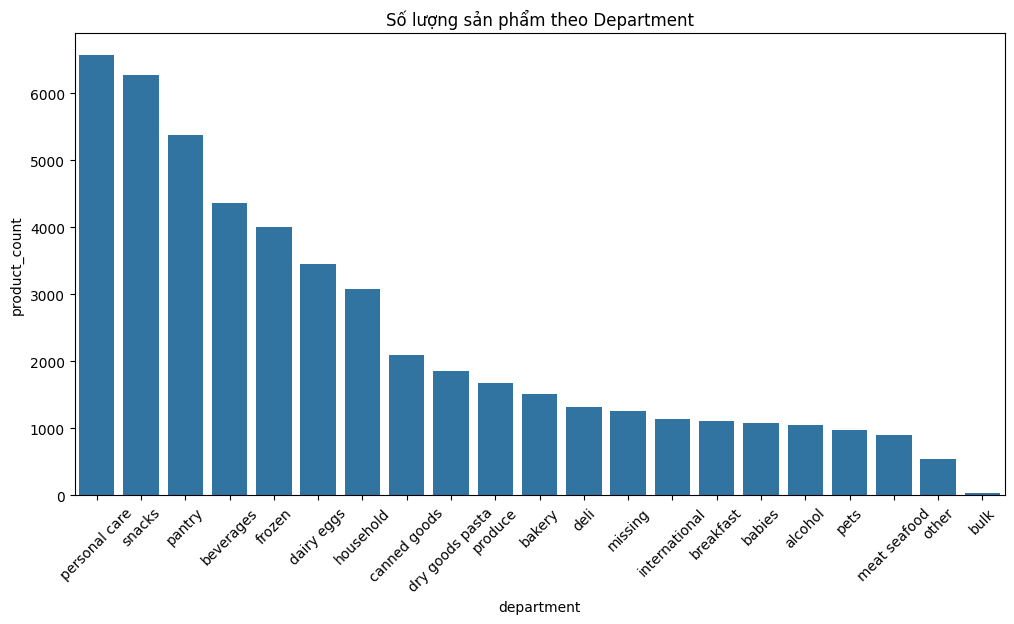

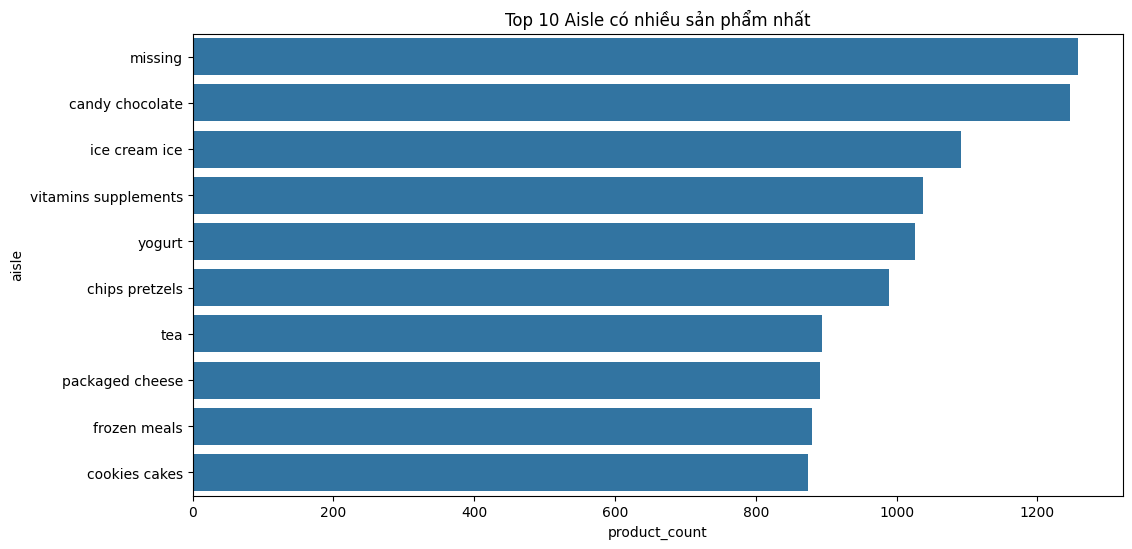

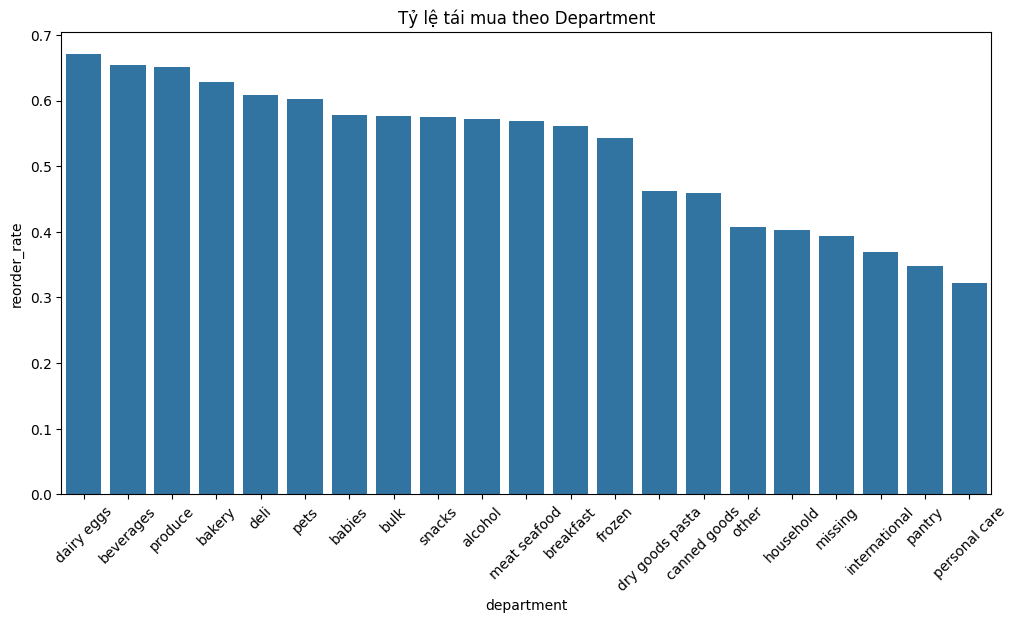

In [4]:
# Phân tích phân bố sản phẩm theo department
dept_products = products.groupby('department_id').size().reset_index(name='product_count')
dept_products = dept_products.merge(departments, on='department_id')

plt.figure(figsize=(12, 6))
sns.barplot(data=dept_products.sort_values('product_count', ascending=False),
            x='department', y='product_count')
plt.xticks(rotation=45)
plt.title('Số lượng sản phẩm theo Department')
plt.show()

# Top 10 aisle có nhiều sản phẩm nhất
aisle_products = products.groupby('aisle_id').size().reset_index(name='product_count')
aisle_products = aisle_products.merge(aisles, on='aisle_id')
top_aisles = aisle_products.nlargest(10, 'product_count')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_aisles, x='product_count', y='aisle')
plt.title('Top 10 Aisle có nhiều sản phẩm nhất')
plt.show()

# Tính tỷ lệ tái mua theo department
order_products = pd.concat([order_prior, order_train])
product_reorder = order_products.merge(products, on='product_id')\
                               .merge(departments, on='department_id')

dept_reorder = product_reorder.groupby('department')\
    .agg({'reordered': ['count', 'mean']})\
    .reset_index()
dept_reorder.columns = ['department', 'total_orders', 'reorder_rate']

plt.figure(figsize=(12, 6))
sns.barplot(data=dept_reorder.sort_values('reorder_rate', ascending=False),
            x='department', y='reorder_rate')
plt.xticks(rotation=45)
plt.title('Tỷ lệ tái mua theo Department')
plt.show()

# 2. Phân tích Pattern Thời gian

Phân tích về:
- Phân bố đơn hàng theo giờ trong ngày
- Phân bố đơn hàng theo ngày trong tuần
- Khoảng thời gian giữa các đơn hàng
- Tần suất mua hàng của khách hàng

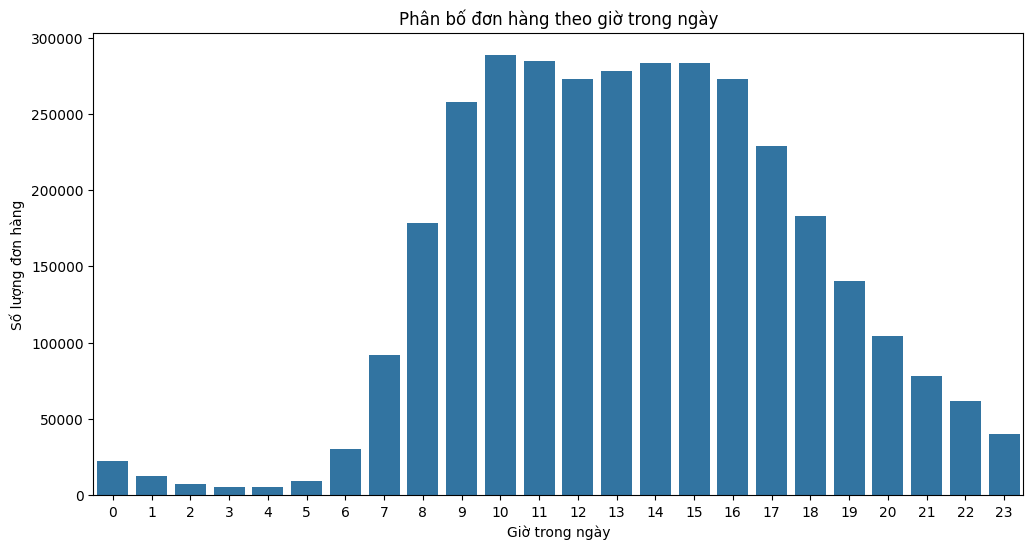

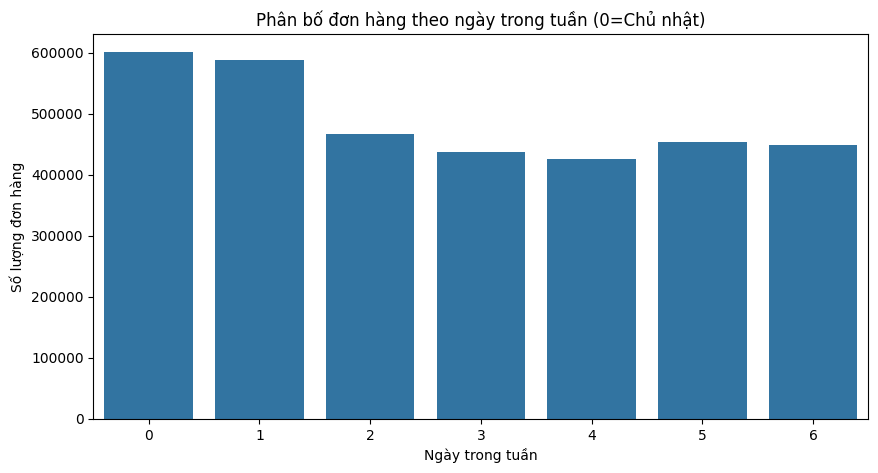

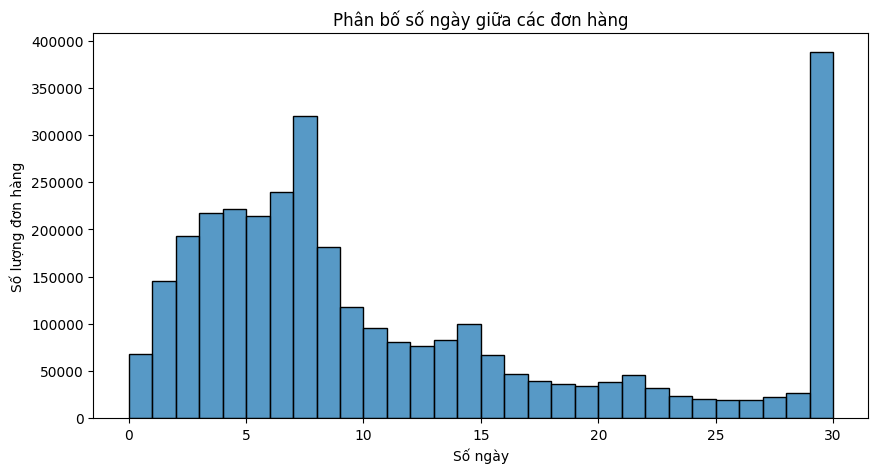

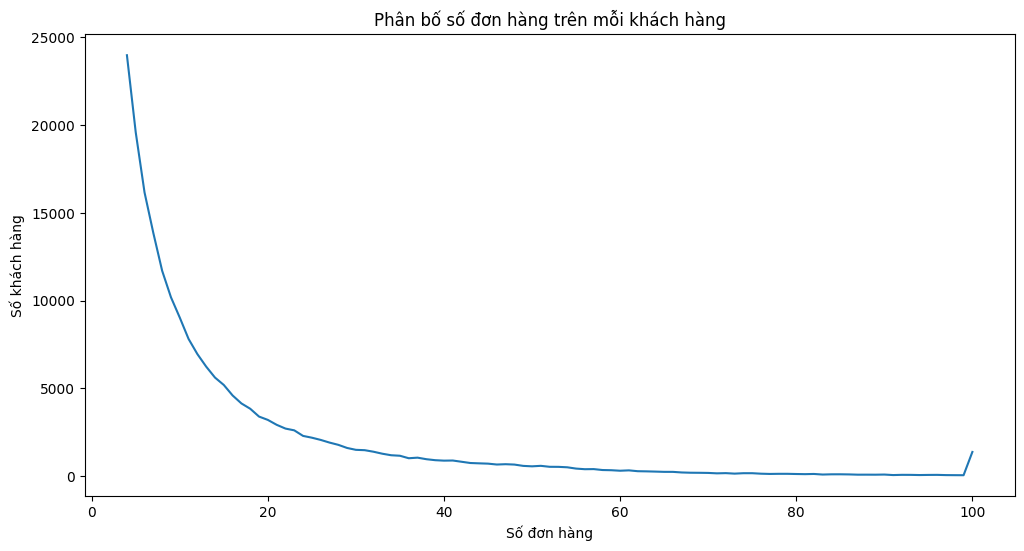

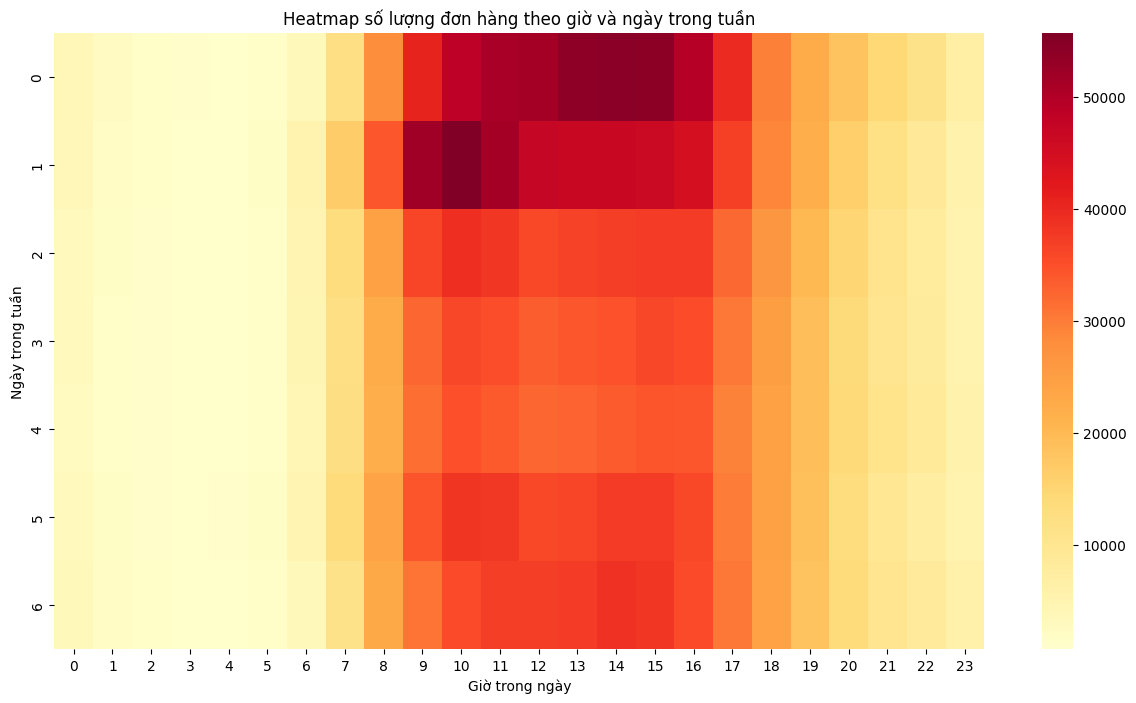

In [5]:
# Phân bố đơn hàng theo giờ
plt.figure(figsize=(12, 6))
sns.countplot(data=orders, x='order_hour_of_day')
plt.title('Phân bố đơn hàng theo giờ trong ngày')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Số lượng đơn hàng')
plt.show()

# Phân bố đơn hàng theo ngày trong tuần
plt.figure(figsize=(10, 5))
sns.countplot(data=orders, x='order_dow')
plt.title('Phân bố đơn hàng theo ngày trong tuần (0=Chủ nhật)')
plt.xlabel('Ngày trong tuần')
plt.ylabel('Số lượng đơn hàng')
plt.show()

# Phân tích khoảng thời gian giữa các đơn hàng
plt.figure(figsize=(10, 5))
sns.histplot(data=orders[orders['days_since_prior_order'].notna()], 
             x='days_since_prior_order', bins=30)
plt.title('Phân bố số ngày giữa các đơn hàng')
plt.xlabel('Số ngày')
plt.ylabel('Số lượng đơn hàng')
plt.show()

# Tần suất mua hàng của khách hàng
user_frequency = orders.groupby('user_id')['order_number'].max().value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(user_frequency.index, user_frequency.values)
plt.title('Phân bố số đơn hàng trên mỗi khách hàng')
plt.xlabel('Số đơn hàng')
plt.ylabel('Số khách hàng')
plt.show()

# Heatmap giờ và ngày trong tuần
hour_dow = orders.groupby(['order_dow', 'order_hour_of_day']).size().unstack()
plt.figure(figsize=(15, 8))
sns.heatmap(hour_dow, cmap='YlOrRd')
plt.title('Heatmap số lượng đơn hàng theo giờ và ngày trong tuần')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Ngày trong tuần')
plt.show()

# 3. Phân tích Hành vi Khách hàng

Phân tích về:
- Số lượng sản phẩm trong mỗi đơn hàng
- Tỷ lệ tái mua của khách hàng
- Các sản phẩm thường được mua cùng nhau
- Sự trung thành với sản phẩm của khách hàng

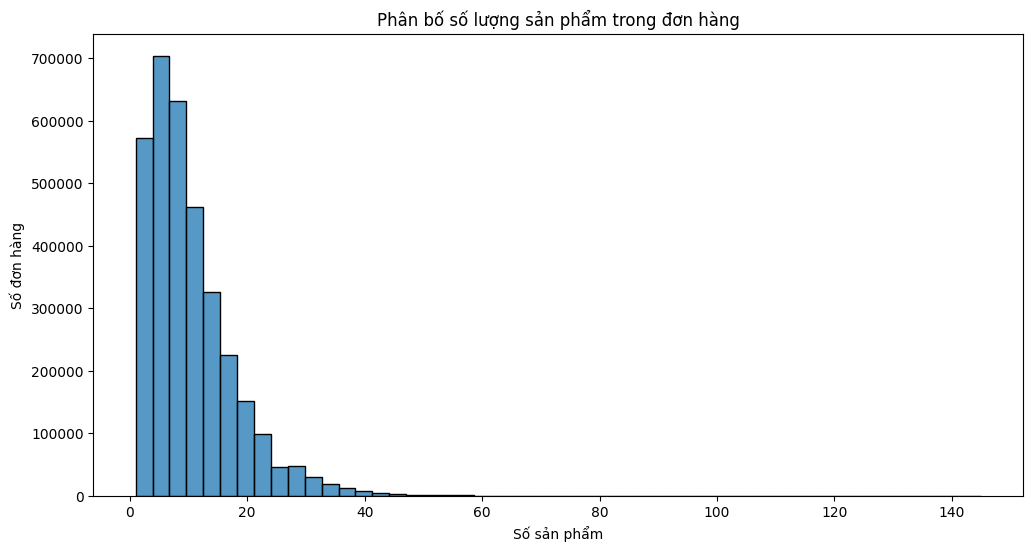

Trung bình số sản phẩm mỗi đơn: 10.11
Trung vị số sản phẩm mỗi đơn: 8.00


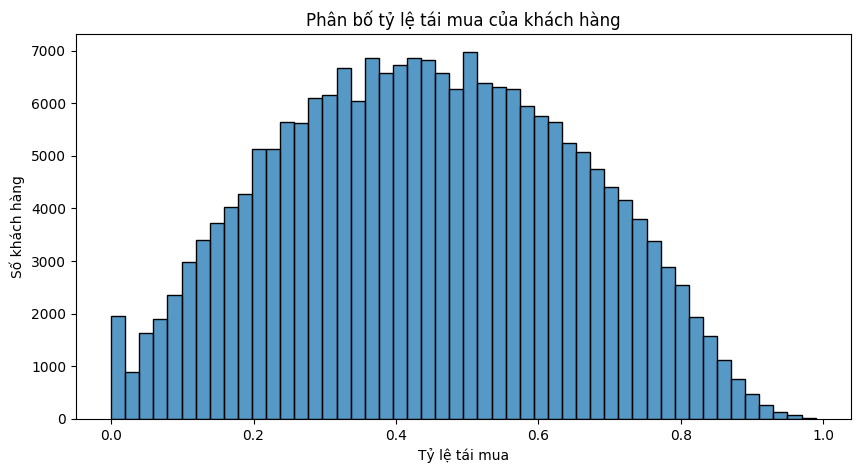

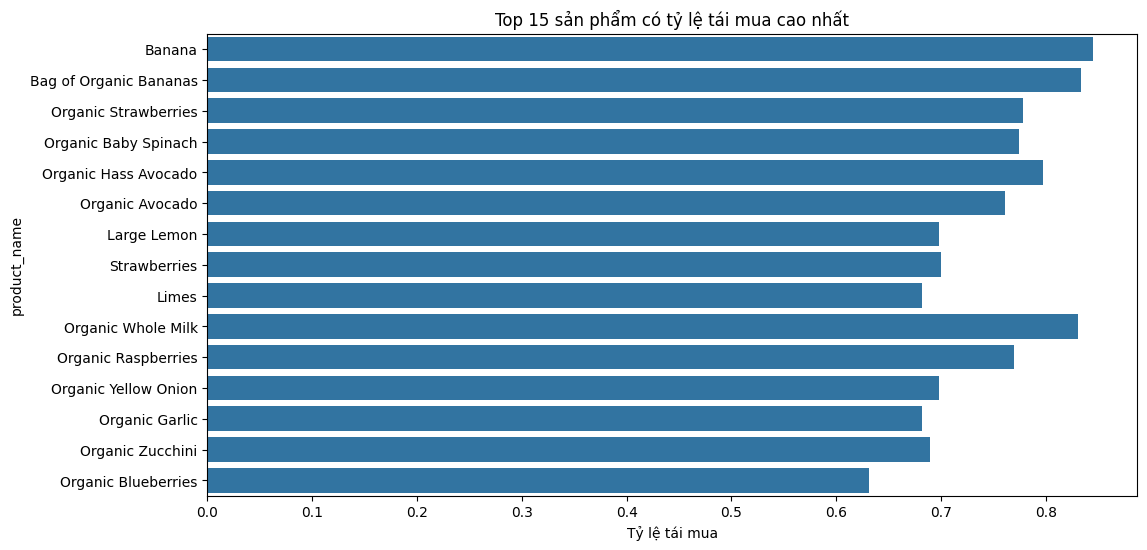

In [6]:
# Phân tích số lượng sản phẩm trong đơn hàng
order_sizes = order_products.groupby('order_id').size()
plt.figure(figsize=(12, 6))
sns.histplot(order_sizes, bins=50)
plt.title('Phân bố số lượng sản phẩm trong đơn hàng')
plt.xlabel('Số sản phẩm')
plt.ylabel('Số đơn hàng')
plt.show()

print(f"Trung bình số sản phẩm mỗi đơn: {order_sizes.mean():.2f}")
print(f"Trung vị số sản phẩm mỗi đơn: {order_sizes.median():.2f}")

# Tỷ lệ tái mua theo khách hàng
user_reorder_rates = order_products.merge(orders, on='order_id')\
    .groupby('user_id')['reordered'].mean()

plt.figure(figsize=(10, 5))
sns.histplot(user_reorder_rates, bins=50)
plt.title('Phân bố tỷ lệ tái mua của khách hàng')
plt.xlabel('Tỷ lệ tái mua')
plt.ylabel('Số khách hàng')
plt.show()

# Top 15 sản phẩm được tái mua nhiều nhất
top_reordered = order_products.merge(products, on='product_id')\
    .groupby('product_name')\
    .agg({'reordered': ['count', 'mean']})\
    .sort_values(('reordered', 'count'), ascending=False)\
    .head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_reordered.reset_index(), 
            y='product_name', 
            x=('reordered', 'mean'))
plt.title('Top 15 sản phẩm có tỷ lệ tái mua cao nhất')
plt.xlabel('Tỷ lệ tái mua')
plt.show()

# Kết luận và Insights

Từ phân tích EDA, chúng ta có thể rút ra các insights quan trọng:

1. **Pattern thời gian**:
   - Đơn hàng tập trung vào các giờ cao điểm
   - Có sự khác biệt rõ rệt giữa các ngày trong tuần
   - Phần lớn khách hàng đặt hàng lại sau 7-10 ngày

2. **Hành vi khách hàng**:
   - Trung bình mỗi đơn hàng có X sản phẩm
   - Tỷ lệ tái mua cao ở một số danh mục nhất định
   - Có mối tương quan giữa thời gian mua và loại sản phẩm

3. **Đặc điểm sản phẩm**:
   - Một số department có tỷ lệ tái mua cao hơn hẳn
   - Top sản phẩm bán chạy chủ yếu là hàng thiết yếu
   - Có pattern rõ ràng trong việc mua sắm theo department

4. **Gợi ý cho mô hình**:
   - Sử dụng features thời gian
   - Tách biệt theo department/aisle
   - Tập trung vào pattern tái mua
   - Xem xét yếu tố theo mùa/tuần